In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
import math

from statsmodels.graphics import tsaplots

In [235]:
path = r"\\daily-treasury-rates_data.csv"
df = pd.read_csv(path)
df['Date'] = df['Date'].astype('datetime64[ns]')

df = df.sort_values(by = 'Date', ascending =True)

base = df['2 Yr'].iloc[-1] # Base interest rate for a 2-yr CD
base

4.98

<Axes: title={'center': 'History of 2-Year Interest Rates (%)'}, xlabel='Date'>

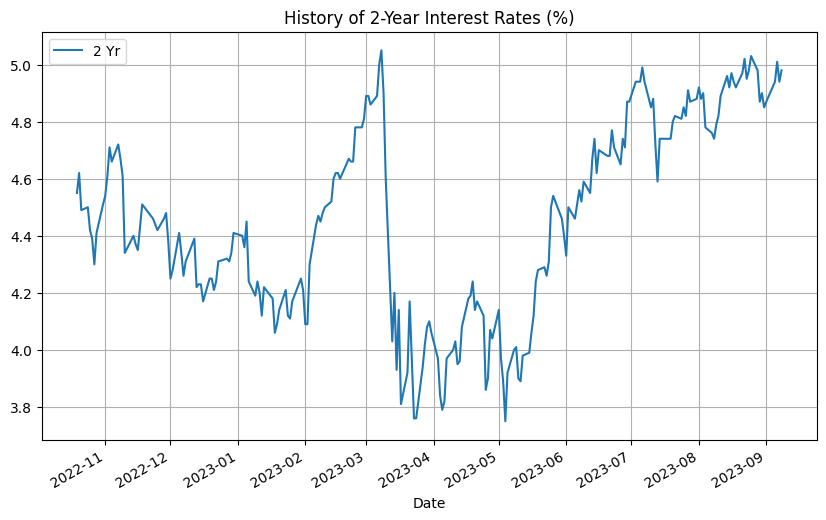

In [226]:
df.plot(x ='Date',y=['2 Yr'],grid =True, title ='History of 2-Year Interest Rates (%)', figsize =[10,6])

In [208]:
df['1Yr-Chg'] = df['1 Yr'].apply(lambda x: math.log(x)).diff(1)

df = df.dropna()

df.tail()
#df[['Date','3 Mo', 'd-Chg-3 Mo']].plot(x ='Date', secondary_y =['d-Chg-3 Mo'],grid =True, title ='History of 3 Month Interest Rates (%)', figsize =[10,6])

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,1Yr-Chg
4,2023-09-01,5.51,5.55,5.53,5.58,5.47,5.36,4.87,4.57,4.29,4.27,4.18,4.48,4.29,-0.001864
3,2023-09-05,5.51,5.56,5.55,5.59,5.51,5.42,4.94,4.65,4.37,4.35,4.27,4.56,4.38,0.011132
2,2023-09-06,5.52,5.55,5.55,5.60,5.52,5.44,5.01,4.73,4.44,4.39,4.30,4.56,4.37,0.003683
1,2023-09-07,5.52,5.56,5.53,5.59,5.50,5.40,4.94,4.66,4.38,4.35,4.27,4.55,4.36,-0.007380
0,2023-09-08,5.52,5.56,5.55,5.60,5.49,5.42,4.98,4.68,4.39,4.35,4.26,4.52,4.33,0.003697


In [228]:
#Stdard Deviation for Daily Change 

# Mean for Daily Rate Change 

[df['1Yr-Chg'].std(),df['1Yr-Chg'].mean()]

[0.01752625142398163, 0.0008341633124452049]

<Axes: ylabel='Frequency'>

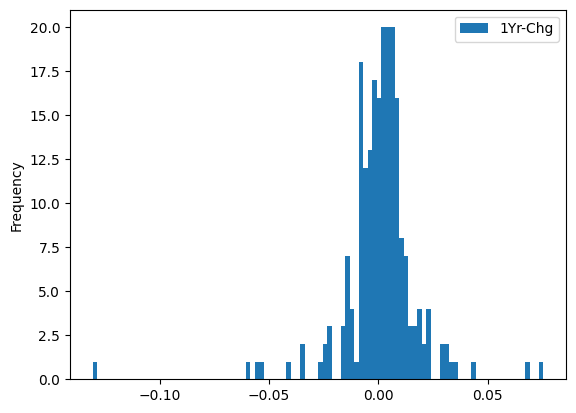

In [138]:
df.plot.hist( y= '1Yr-Chg', bins =100)

In [229]:
mu, sigma = 0.0008, 0.0175*math.sqrt(130)
s = np.random.normal(mu, sigma, 4000)

sim = pd.DataFrame(data = s)
#plt.hist(s, bins ='auto')

In [230]:
#We assume rate is log-normal, or log is normally distributed
sim.columns =['log_chg']

#rates['rate']= rates['log_chg'].apply(lambda x: math.exp(x)*base)

sim['rate']= sim.log_chg.apply(lambda x: math.exp(x)*base)

sim['payoff']= sim['rate'].apply(lambda x: max(base -x,0)*0.5)

avg = sim['payoff'].mean()


Next we will price a callable CD. A callable CD is a CD with an option given to the Bank to call back or retire the CD earlier than maturity if interest rate falls. This call feature enhances the position of the Bank as the Bank can save on interest cost if interest rate delcines after issuance of the CD. As such, customer may demand higher interest rate to compensate for potential loss of interest when interest rate delcines. 

The question is: that is the "fair" compensation for bearing this risk? This requires a monte-carlo simulation of potential interest rate paths between now and maturity of the CD. Below we will price the following callable CD:

The current CD rate is 4.98% for 2 year. JPM Morgan plans to issue a 2-yr CD, callable once in 1 yr. You are asked to proposed the interest rate on this new CD. What should your approach be?

1. Simulate potential interest rate scenarios in 1 year for 1 year forward rate. 
2. Along each path, you decide when the bank should call the CD based on the simulated interest rate level. If a CD is called, JPM Moragn will save the interest rate between the time of call and the maturity of the original CD.
3. You average the potential savings for JPM, and the result is the "fair" value for the option, which should be credit to the customer for the higher rate.

In [233]:
#convert daily volatility to 1-yr volatility with square-root rule

mu, sigma = 0.001, 0.027*math.sqrt(260)
s = np.random.normal(mu, sigma, 1000)
#simular the interest rates and put them in a pandas data frame
sim = pd.DataFrame(data = s)

avg

0.37388389829757207

In [236]:
sim.columns =['log_chg']
#rates['rate']= rates['log_chg'].apply(lambda x: math.exp(x)*base)
sim['rate']= sim.log_chg.apply(lambda x: math.exp(x)*base)
sim['payoff']= sim['rate'].apply(lambda x: max(base -x,0)*0.5)
#The average benefit from the call feature is:
avg = sim['payoff'].mean()
#This should be the risk premium added to the non-callable CD. 
print ("The callable CD annual rate should be in %: ", avg+base, " as compared to the non-callable CD rate of (%) ", base)

The callable CD annual rate should be in %:  5.295738399739053  as compared to the non-callable CD rate of (%)  4.98
